In [201]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os

In [259]:
# Device Configuration and Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
latent_dim = 64
epochs = 75
lr = 2e-3
save_dir = "./vae_checkpoints"
os.makedirs(save_dir, exist_ok=True)

In [260]:
# Dataset Loading with Train/Validation Split
transform = transforms.ToTensor()
full_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_len = int(0.7 * len(full_dataset))
val_len = len(full_dataset) - train_len
train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [261]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # 28x28 → 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),

            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 14x14 → 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),  # 7x7 → 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1)
        )

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128 * 7 * 7)

        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 7x7 → 14x14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 14x14 → 28x28
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(-1, 128, 7, 7)
        x = self.decoder_deconv(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div, recon_loss, kl_div

In [262]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

def sigmoid_beta_schedule(epoch, max_epochs, max_beta=1.2, steepness=10):
    x = (epoch - max_epochs / 2) / (max_epochs / steepness)
    return max_beta / (1 + math.exp(-x))

def train_vae(model, train_loader, val_loader, epochs, optimizer, device,
              model_path='vae_model.pth', save_every=5, load_model=False):
    os.makedirs('models', exist_ok=True)

    if os.path.exists(model_path) and load_model:
        print(f"🔁 Loading existing model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        return model

    model.train()
    for epoch in range(1, epochs + 1):
        beta = sigmoid_beta_schedule(epoch, epochs)
        train_loss = 0
        train_recon = 0
        train_kl = 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch}/{epochs}]", leave=True)
        for batch_idx, (x, _) in enumerate(loop):
            x = x.to(device)

            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)
            loss, recon_loss, kl_div = vae_loss(x_recon, x, mu, logvar, beta)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_recon += recon_loss.item()
            train_kl += kl_div.item()

            loop.set_postfix(loss=loss.item() / len(x), recon=recon_loss.item() / len(x), kl=kl_div.item() / len(x))

        # Validation phase
        model.eval()
        val_loss, val_recon, val_kl = 0, 0, 0
        with torch.no_grad():
            for x_val, _ in val_loader:
                x_val = x_val.to(device)
                x_recon, mu, logvar = model(x_val)
                loss, recon_loss, kl_div = vae_loss(x_recon, x_val, mu, logvar, beta)

                val_loss += loss.item()
                val_recon += recon_loss.item()
                val_kl += kl_div.item()

        val_size = len(val_loader.dataset)
        model.train()

        # Save every N epochs
        if epoch % save_every == 0:
            save_path = 'models/vae_model.pth'
            torch.save(model.state_dict(), save_path)

    # Save final model
    torch.save(model.state_dict(), model_path)
    print(f"✅ Training complete. Model saved to {model_path}")
    return model

In [263]:
model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model = train_vae(model, train_loader, val_loader,
                  epochs=epochs, optimizer=optimizer,
                  device=device, model_path='models/vae_model.pth',
                  save_every=5, load_model=False)

Epoch [75/75]: 100%|██████████| 329/329 [00:05<00:00, 55.29it/s, kl=23.2, loss=99.6, recon=71.9]


✅ Training complete. Model saved to models/vae_model.pth


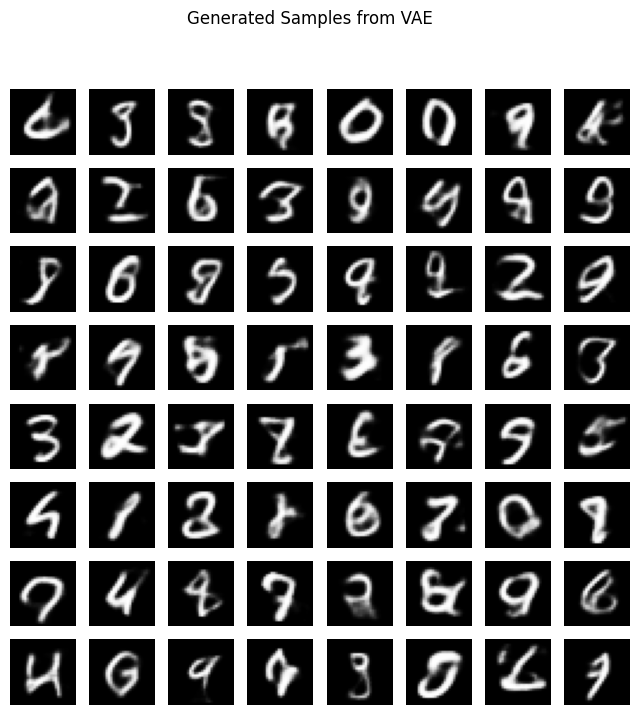

In [264]:
import matplotlib.pyplot as plt

def generate_samples(model, num_samples=16, latent_dim=64, device='cuda'):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = model.decode(z).cpu()

    generated = generated.view(-1, 1, 28, 28)
    grid_cols = int(num_samples ** 0.5)
    fig, axes = plt.subplots(grid_cols, grid_cols, figsize=(grid_cols, grid_cols))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(generated[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle("Generated Samples from VAE")
    plt.show()

# Example usage:
generate_samples(model, num_samples=64, latent_dim=latent_dim, device=device)

In [265]:
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.nn.functional as F
import torchvision.transforms as T

def compute_fid_score(model, val_loader, latent_dim=64, num_samples=1000, device='cuda'):
    model.eval()
    fid = FrechetInceptionDistance(feature=2048).to(device)

    resize = T.Resize((299, 299))
    to_uint8 = lambda x: (x * 255).clamp(0, 255).to(torch.uint8)

    real_images = []
    generated_images = []

    with torch.no_grad():
        count = 0
        for x_real, _ in val_loader:
            x_real = x_real.to(device)
            batch_size = x_real.size(0)

            z = torch.randn(batch_size, latent_dim).to(device)
            x_fake = model.decode(z)

            # Resize and convert to uint8
            x_real_resized = to_uint8(resize(x_real.expand(-1, 3, -1, -1)))
            x_fake_resized = to_uint8(resize(x_fake.expand(-1, 3, -1, -1)))

            fid.update(x_real_resized, real=True)
            fid.update(x_fake_resized, real=False)

            count += batch_size
            if count >= num_samples:
                break

    score = fid.compute().item()
    print(f"✅ FID Score over {min(count, num_samples)} samples: {score:.2f}")
    return score

# Example:
fid_score = compute_fid_score(model, val_loader, latent_dim=latent_dim, num_samples=1000, device=device)

✅ FID Score over 1000 samples: 36.75


### PCA Analysis

In [356]:
import numpy as np
from sklearn.decomposition import PCA

def get_latent_vectors(dataset):
    model.to(device)
    model.eval()
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    latent_vectors = []
    total_samples = len(dataset)  # Total number of images

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Extracting Latent Vectors", unit="batch")
        for images, _ in progress_bar:
            images = images.to(device)
            z, _ = model.encode(images)
            latent_vectors.append(z.cpu().numpy())
            
            # Update progress description
            progress_bar.set_postfix(processed=len(latent_vectors) * dataloader.batch_size, total=total_samples)

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    return latent_vectors

def get_pca_components(data, n_components=5):
    pca = PCA(n_components)
    pca.fit(data)
    return pca.components_

def get_z_pair(principal_vec, z_vectors, n=5, epsilon=2.0):
    z_modifieds = []
    principal_vec = torch.tensor(principal_vec, dtype=torch.float32, device=device)

    for z in z_vectors:
        z_modified = z + epsilon * principal_vec
        z_modifieds.append(z_modified)

    return torch.stack(z_modifieds)

In [416]:
latent_vectors = get_latent_vectors(train_dataset)
principal_components = get_pca_components(latent_vectors, n_components=5)
print("PCA fit done")

Extracting Latent Vectors: 100%|██████████| 1313/1313 [00:04<00:00, 278.03batch/s, processed=42016, total=42000]


PCA fit done


In [417]:
len(principal_components)

5

In [418]:
import matplotlib.pyplot as plt

def plot_image_pairs(img_original, img_modified, title="Original vs Modified"):
    assert len(img_original) == len(img_modified), "Both lists must have the same length!"
    
    num_images = len(img_original)
    fig, axes = plt.subplots(num_images, 2, figsize=(4, num_images * 2))
    fig.suptitle(title, fontsize=14)

    # Flatten axes for consistent indexing
    axes = axes.reshape(num_images, 2) if num_images > 1 else [axes]
    
    for i in range(num_images):
        original = img_original[i].squeeze().cpu().detach().numpy()
        modified = img_modified[i].squeeze().cpu().detach().numpy()
        
        axes[i][0].imshow(original, cmap='gray')
        axes[i][0].set_title("Original", fontsize=10)
        axes[i][0].axis("off")
        
        axes[i][1].imshow(modified, cmap='gray')
        axes[i][1].set_title("Modified", fontsize=10)
        axes[i][1].axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [458]:
z = torch.randn(n, latent_dim, device=device)

In [468]:
prin_comp_idx = 4
assert(prin_comp_idx < len(principal_components))

n = 3
z_modified = get_z_pair(principal_components[prin_comp_idx], z, epsilon=-2.5)

In [469]:
with torch.no_grad():
    model.eval()
    img_original = model.decode(z).cpu().detach()
    img_modified = model.decode(z_modified).cpu().detach()

# Scale from [-1, 1] → [0, 1]
img_original = (img_original + 1) / 2
img_modified = (img_modified + 1) / 2

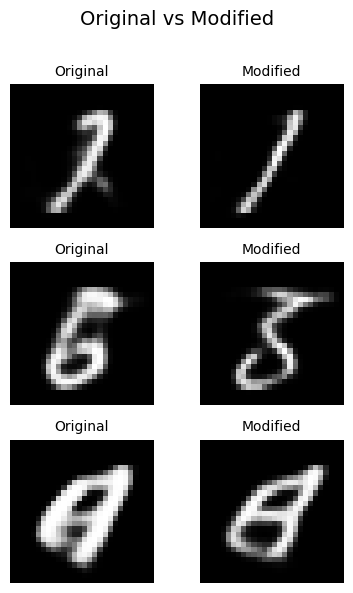

In [470]:
plot_image_pairs(img_original, img_modified)